<a href="https://colab.research.google.com/github/atal5/ML_DL_CLASS/blob/master/Autoencoders_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

import numpy as np
np.random.seed(123)

In [2]:
#Load data and normalize them
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.max(),X_train.min())

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape, y_train.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
255 0
(60000, 28, 28) (60000,)


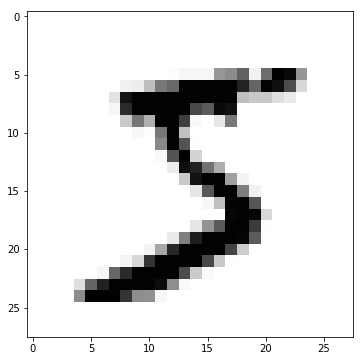

In [3]:
plt.imshow(X_train[0],cmap='Greys')

## Stacked Autoencoder

In [0]:
from keras.layers import Dense, Input, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

In [0]:
input_shape = X_train.shape[1:]
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
learning_rate = 0.01
l2_reg = 0.0001

In [7]:
# for encoder1
input_tensor = Input(shape=input_shape)
flattened = Flatten()(input_tensor)
hidden1 = Dense(n_hidden1, activation='elu', kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(l2_reg))(flattened)
print('input_tensor: ',input_tensor)
print('flattened: ',flattened)
print('hidden1: ',hidden1)

input_tensor:  Tensor("input_2:0", shape=(?, 28, 28), dtype=float32)
flattened:  Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
hidden1:  Tensor("dense_2/Elu:0", shape=(?, 300), dtype=float32)


In [8]:
# for encoder2
input_enc2 = Input(shape=(n_hidden1,))
hidden2 = Dense(n_hidden2, activation='elu', kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(l2_reg))(input_enc2)
print('input_enc2: ',input_enc2)
print('hidden2: ',hidden2)

input_enc2:  Tensor("input_3:0", shape=(?, 300), dtype=float32)
hidden2:  Tensor("dense_3/Elu:0", shape=(?, 150), dtype=float32)


In [9]:
# for decoder2
input_dec2 = Input(shape=(n_hidden2,))
hidden3 = Dense(n_hidden3, activation='elu', kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(l2_reg))(input_dec2)
print('input_dec2: ',input_dec2)
print('hidden3: ',hidden3)

input_dec2:  Tensor("input_4:0", shape=(?, 150), dtype=float32)
hidden3:  Tensor("dense_4/Elu:0", shape=(?, 300), dtype=float32)


In [10]:
input_dec1 = Input(shape=(n_hidden1,))
flattened_outputs = Dense(np.prod(input_shape), activation='sigmoid', kernel_initializer='he_normal', 
                          kernel_regularizer=regularizers.l2(l2_reg))(input_dec1)
outputs = Reshape(input_shape)(flattened_outputs)
print('input_dec1: ',input_dec1)
print('flattened_outputs: ',flattened_outputs)
print('outputs: ',outputs)

input_dec1:  Tensor("input_5:0", shape=(?, 300), dtype=float32)
flattened_outputs:  Tensor("dense_5/Sigmoid:0", shape=(?, 784), dtype=float32)
outputs:  Tensor("reshape_1/Reshape:0", shape=(?, 28, 28), dtype=float32)


In [0]:
from keras.utils import plot_model

In [0]:
# encoder
encoder1 = Model(input_tensor, hidden1, name='encoder_1')
encoder2 = Model(input_enc2, hidden2, name='encoder_2')
encoder = Model(input_tensor, encoder2(encoder1(input_tensor)), name='encoder')
plot_model(encoder1, to_file='encoder1.png',show_shapes=True,show_layer_names=True)
plot_model(encoder2, to_file='encoder2.png',show_shapes=True,show_layer_names=True)
plot_model(encoder, to_file='encoder.png',show_shapes=True,show_layer_names=True)

In [13]:
!ls

'documents-MachineLearning_iLykei-DeepLearningModels-sales-of-shampoo-over-a-three-ye.csv?token=ALLJKZG4OLJ4WO7RPM3CIAC46WV6U'
 encoder1.png
 encoder2.png
 encoder.png
 sample_data


In [0]:
# decoder
decoder2 = Model(input_dec2, hidden3, name='decoder_2')
decoder1 = Model(input_dec1, outputs, name='decoder_1')
decoder = Model(input_dec2, decoder1(decoder2(input_dec2)), name='decoder')
plot_model(decoder2, to_file='decoder2.png',show_shapes=True,show_layer_names=True)
plot_model(decoder1, to_file='decoder1.png',show_shapes=True,show_layer_names=True)
plot_model(decoder, to_file='decoder.png',show_shapes=True,show_layer_names=True)

## Autoencoder assembled

In [0]:
# autoencoder
autoencoder = Model(input_tensor, decoder(encoder(input_tensor)), name='autoencoder')
plot_model(autoencoder, to_file='autoencoder.png',show_shapes=True,show_layer_names=True)

In [16]:
autoencoder.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
autoencoder.save_weights('ae_initial_weights.h5') # save initial weights (to re-produce results in the next sections)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 150)               280650    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            281284    
Total params: 561,934
Trainable params: 561,934
Non-trainable params: 0
_________________________________________________________________


### Train Autoencoder

In [17]:
n_epochs = 4
batch_size = 150

autoencoder.fit(X_train, X_train,
                epochs=n_epochs,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 3s 43us/step - loss: 0.2193 - val_loss: 0.1512
Epoch 2/4
60000/60000 [==============================] - 2s 30us/step - loss: 0.1510 - val_loss: 0.1550
Epoch 3/4
60000/60000 [==============================] - 2s 30us/step - loss: 0.1498 - val_loss: 0.1470
Epoch 4/4
60000/60000 [==============================] - 2s 30us/step - loss: 0.1482 - val_loss: 0.1452


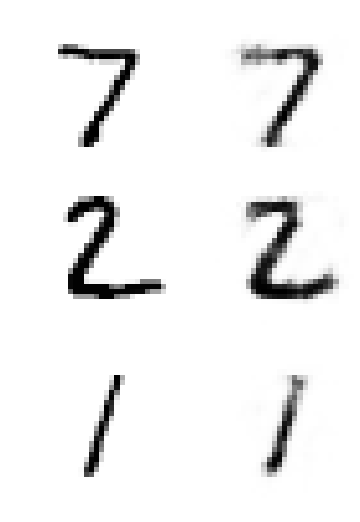

In [19]:
n_test_digits = 3

imgs = X_test[:n_test_digits]
reconstructed_imgs = autoencoder.predict(imgs)


def plot_imgs(*args, n_imgs=None):
    n_cols = len(args)
    if n_imgs is None:
        n_imgs = args[0].shape[0]
    fig = plt.figure(figsize=(3 * n_cols, 3 * n_imgs))
    for row in range(n_imgs):
        for col in range(n_cols):
            plt.subplot(n_imgs, n_cols, row * n_cols + col + 1)
            plt.imshow(args[col][row], cmap='Greys', interpolation='nearest')
            plt.axis('off')


plot_imgs(imgs, reconstructed_imgs)

In [0]:
autoencoder.load_weights('ae_initial_weights.h5')

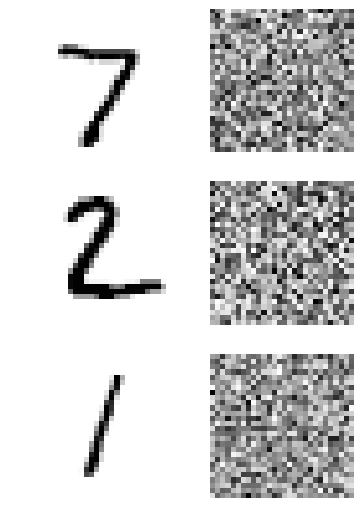

In [21]:
n_test_digits = 3
imgs = X_test[:n_test_digits]
reconstructed_imgs = autoencoder.predict(imgs)
plot_imgs(imgs, reconstructed_imgs)

In [0]:
autoencoder1 = Model(input_tensor, decoder1(encoder1(input_tensor)), name='autoencoder_1')
autoencoder1.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
plot_model(autoencoder1, to_file='autoencoder1.png',show_shapes=True,show_layer_names=True)

In [23]:
n_epochs = 4
batch_size = 150

autoencoder1.fit(X_train, X_train,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 33us/step - loss: 0.1844 - val_loss: 0.1585
Epoch 2/4
60000/60000 [==============================] - 2s 26us/step - loss: 0.1570 - val_loss: 0.1534
Epoch 3/4
60000/60000 [==============================] - 2s 26us/step - loss: 0.1549 - val_loss: 0.1528
Epoch 4/4
60000/60000 [==============================] - 2s 26us/step - loss: 0.1542 - val_loss: 0.1526


In [24]:
X_train_intermediate = encoder1.predict(X_train)
X_test_intermediate = encoder1.predict(X_test)
X_train_intermediate.shape,X_test_intermediate.shape

((60000, 300), (10000, 300))

In [0]:
autoencoder2 = Model(input_enc2, decoder2(encoder2(input_enc2)), name='autoencoder_2')
autoencoder2.compile(optimizer=Adam(learning_rate), loss='mse')
plot_model(autoencoder2, to_file='autoencoder2.png',show_shapes=True,show_layer_names=True)

In [26]:
n_epochs = 4
batch_size = 150

autoencoder2.fit(X_train_intermediate, X_train_intermediate,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_data=(X_test_intermediate, X_test_intermediate))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 26us/step - loss: 0.1833 - val_loss: 0.0376
Epoch 2/4
60000/60000 [==============================] - 1s 22us/step - loss: 0.0307 - val_loss: 0.0340
Epoch 3/4
60000/60000 [==============================] - 1s 21us/step - loss: 0.0264 - val_loss: 0.0281
Epoch 4/4
60000/60000 [==============================] - 1s 20us/step - loss: 0.0195 - val_loss: 0.0176


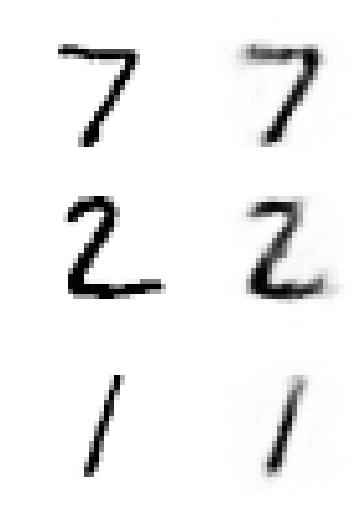

In [27]:
n_test_digits = 3

imgs = X_test[:n_test_digits]
reconstructed_imgs = autoencoder.predict(imgs)

plot_imgs(imgs, reconstructed_imgs)

In [28]:
w = encoder1.get_weights()[0]
w.shape

(784, 300)

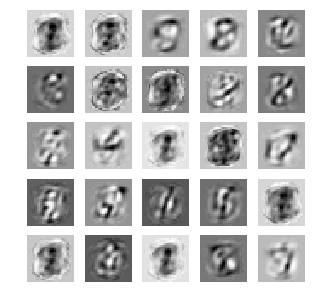

In [29]:
R, C = 5, 5  # rows, columns
plt.figure(figsize=(R, C))
for i in range(R*C):
    plt.subplot(R, C, i + 1)
    plt.imshow(w[:,i].reshape((28, 28)), cmap='Greys', interpolation='nearest')
    plt.axis('off')

## Unsupervised pretraining for supervised problem

In [30]:
X_train_codings = encoder.predict(X_train)
X_test_codings = encoder.predict(X_test)
print(X_train_codings.shape, X_test_codings.shape)

(60000, 150) (10000, 150)


In [31]:
input_classifier = Input(shape=(n_hidden2,))
softmax_predictions = Dense(10, activation='softmax', kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(l2_reg))(input_classifier)

classifier = Model(inputs=input_classifier, outputs=softmax_predictions, name='classifier')

classifier.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1510      
Total params: 1,510
Trainable params: 1,510
Non-trainable params: 0
_________________________________________________________________


In [32]:
n_epochs = 4
batch_size = 150

classifier.fit(X_train_codings, y_train,
               epochs=n_epochs,
               batch_size=batch_size,
               validation_data=(X_train_codings, y_train))

Train on 60000 samples, validate on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 27us/step - loss: 0.4535 - acc: 0.8651 - val_loss: 0.3444 - val_acc: 0.9003
Epoch 2/4
60000/60000 [==============================] - 1s 24us/step - loss: 0.3416 - acc: 0.9011 - val_loss: 0.3512 - val_acc: 0.8945
Epoch 3/4
60000/60000 [==============================] - 1s 24us/step - loss: 0.3289 - acc: 0.9059 - val_loss: 0.3208 - val_acc: 0.9081
Epoch 4/4
60000/60000 [==============================] - 2s 25us/step - loss: 0.3226 - acc: 0.9079 - val_loss: 0.3112 - val_acc: 0.9118


In [33]:
import pandas as pd
y_test_predictions = classifier.predict(X_test_codings)
print('Class probabilities: \n',pd.DataFrame(y_test_predictions[:5]).round(2))
print('Actual: ',y_test[:5])

Class probabilities: 
      0     1     2     3     4     5    6    7    8     9
0  0.0  0.00  0.00  0.00  0.00  0.00  0.0  1.0  0.0  0.00
1  0.0  0.00  0.85  0.02  0.00  0.02  0.1  0.0  0.0  0.00
2  0.0  0.99  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.00
3  1.0  0.00  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.00
4  0.0  0.00  0.00  0.00  0.93  0.00  0.0  0.0  0.0  0.06
Actual:  [7 2 1 0 4]


## Stacked Denoising Autoencoder

In [0]:
autoencoder.load_weights('ae_initial_weights.h5')  # load initial weights

import keras.backend as K
from keras.layers import Lambda


def add_noise(x, noise_level = 0.5):
    x = x + K.random_normal(shape=K.shape(x), stddev=noise_level)
    x = K.clip(x, 0., 1.)  # assure 0 <= x <= 1
    return x


noised_img = Lambda(add_noise)(input_tensor)
noiser = Model(input_tensor, noised_img, name='noiser')
denoiser = Model(input_tensor, autoencoder(noiser(input_tensor)), name='denoiser')

denoiser.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')

In [35]:
n_epochs = 4
batch_size = 150

denoiser.fit(X_train, X_train,
             epochs=n_epochs, batch_size=batch_size,
             validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 3s 43us/step - loss: 0.2732 - val_loss: 0.1883
Epoch 2/4
60000/60000 [==============================] - 2s 33us/step - loss: 0.1854 - val_loss: 0.1816
Epoch 3/4
60000/60000 [==============================] - 2s 34us/step - loss: 0.1825 - val_loss: 0.1832
Epoch 4/4
60000/60000 [==============================] - 2s 34us/step - loss: 0.1812 - val_loss: 0.1791


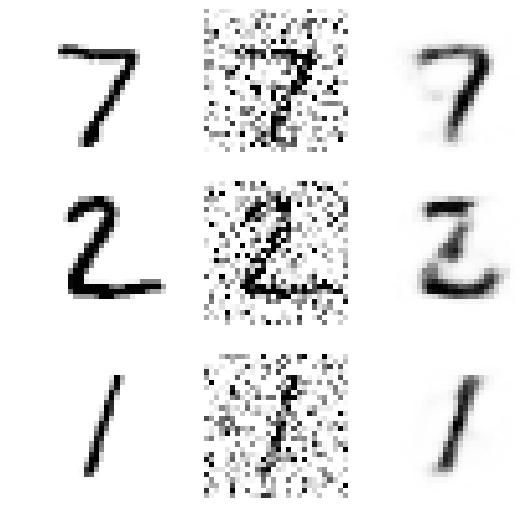

In [36]:
n = 3

imgs = X_test[:n]
noised_imgs = noiser.predict(imgs)
denoised_imgs = autoencoder.predict(noised_imgs)

plot_imgs(imgs, noised_imgs, denoised_imgs)

## Dropout Noise

In [37]:
autoencoder.load_weights('ae_initial_weights.h5')  # reload initial weights

from keras.layers import Dropout

dropout_rate = 0.8  # drop ~80% (!!!) of pixels
dropout_img = Dropout(rate=dropout_rate)(input_tensor, training=True)  # training=True activates dropout during prediction

noiser_dropout = Model(input_tensor, dropout_img, name='noiser_dropuot')
denoiser_dropout = Model(input_tensor, autoencoder(noiser_dropout(input_tensor)), name='denoiser_dropout')    

denoiser_dropout.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
n_epochs = 4
batch_size = 150

denoiser_dropout.fit(X_train, X_train,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 3s 46us/step - loss: 0.2498 - val_loss: 0.2025
Epoch 2/4
60000/60000 [==============================] - 2s 35us/step - loss: 0.2026 - val_loss: 0.1983
Epoch 3/4
60000/60000 [==============================] - 2s 34us/step - loss: 0.1998 - val_loss: 0.1992
Epoch 4/4
60000/60000 [==============================] - 2s 33us/step - loss: 0.1989 - val_loss: 0.1972


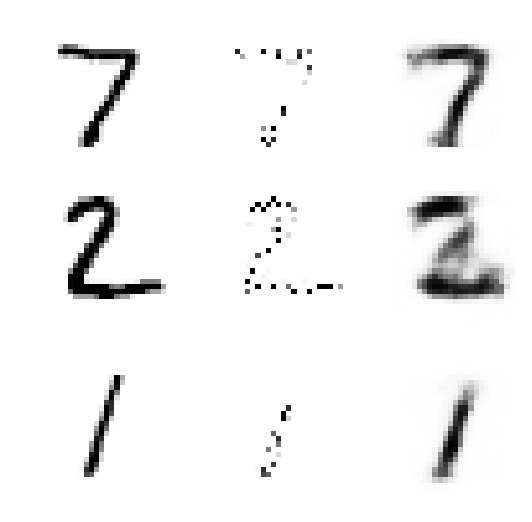

In [39]:
n = 3

imgs = X_test[:n]
noised_imgs = noiser_dropout.predict(imgs)
denoised_imgs = autoencoder.predict(noised_imgs)

plot_imgs(imgs, noised_imgs, denoised_imgs)

## Sparse Autoencoder

In [0]:
def create_autoencoder(input_shape, n_hidden1, sparse=True, sparsity_weight=1e-5):
    # tensors:
    input_tensor = Input(shape=input_shape)
    flattened = Flatten()(input_tensor)
    regularizer = regularizers.l1(sparsity_weight) if sparse else None
    hidden1 = Dense(n_hidden1, activation='relu', kernel_initializer='he_normal', 
                    activity_regularizer=regularizer)(flattened)
    input_decoder = Input(shape=(n_hidden1,))
    flattened_outputs = Dense(np.prod(input_shape), activation='sigmoid', 
                              kernel_initializer='he_normal')(input_decoder)
    outputs = Reshape(input_shape)(flattened_outputs)
    # models:
    encoder = Model(input_tensor, hidden1, name='encoder')
    decoder = Model(input_decoder, outputs, name='decoder')
    autoencoder = Model(input_tensor, decoder(encoder(input_tensor)), name='autoencoder')
    return encoder, decoder, autoencoder


input_shape = X_train.shape[1:]
n_hidden1 = 300
sparsity_weight = 1e-5
encoder, decoder, autoencoder = create_autoencoder(input_shape, n_hidden1, sparse=False)
s_encoder, s_decoder, s_autoencoder = create_autoencoder(input_shape, n_hidden1, 
                                                         sparse=True, sparsity_weight=sparsity_weight)

In [41]:
learning_rate = 0.01
autoencoder.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
s_autoencoder.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
s_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 300)               235500    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            235984    
Total params: 471,484
Trainable params: 471,484
Non-trainable params: 0
_________________________________________________________________


In [42]:
n_epochs = 2
batch_size = 150

autoencoder.fit(X_train, X_train,
                epochs=n_epochs,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

s_autoencoder.fit(X_train, X_train,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 2s 36us/step - loss: 0.0980 - val_loss: 0.0723
Epoch 2/2
60000/60000 [==============================] - 2s 27us/step - loss: 0.0705 - val_loss: 0.0685
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 2s 36us/step - loss: 0.1887 - val_loss: 0.1508
Epoch 2/2
60000/60000 [==============================] - 2s 28us/step - loss: 0.1461 - val_loss: 0.1400


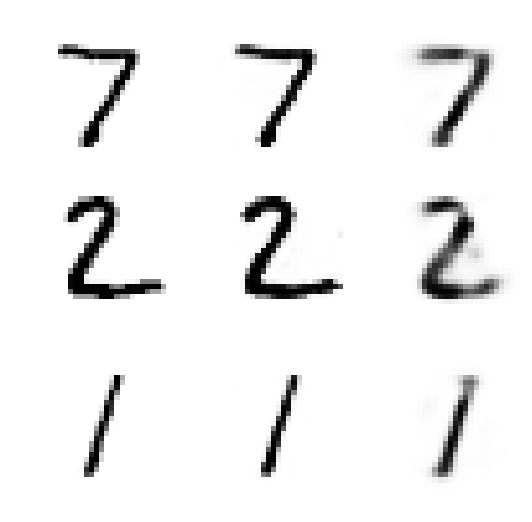

In [43]:
n_test_digits = 3

imgs = X_test
codings = encoder.predict(imgs)
reconstructed_imgs = decoder.predict(codings)
sparse_codings = s_encoder.predict(imgs)
s_reconstructed_imgs = s_decoder.predict(sparse_codings)

plot_imgs(imgs, reconstructed_imgs, s_reconstructed_imgs, n_imgs=n_test_digits)


In [44]:
print('Vanilla autoencoder mean-absolute-codings: ', np.mean(np.abs(codings)))
print('Sparse  autoencoder mean-absolute-codings: ', np.mean(np.abs(sparse_codings)))

Vanilla autoencoder mean-absolute-codings:  1.099936
Sparse  autoencoder mean-absolute-codings:  0.05033188


In [45]:
print('Vanilla autoencoder zero fraction: ', np.mean(codings == 0))
print('Sparse  autoencoder zero fraction: ', np.mean(sparse_codings == 0))

Vanilla autoencoder zero fraction:  0.5448166666666666
Sparse  autoencoder zero fraction:  0.938652
